In [110]:
import os
from functools import reduce
import json                                                                     
import random
from collections import OrderedDict
import pdb
from copy import deepcopy
from operator import itemgetter
from itertools import islice
import matplotlib.pyplot as plt

import pycrfsuite                                                               
import pandas as pd                                                             
import numpy as np    

In [95]:
source_building_name = 'ap_m'
target_building_name = 'ebu3b'
token_type = 'justseparate'
#token_types = ['alphaandnum', 'justseparate']
label_type = 'label'
#label_types = ['label', 'category']
USE_CLUSTER = False
SAMPLE_NUM = 200

data_available_buildings = []

with open('metadata/{0}_char_label_dict.json'.format(target_building_name), 'r') as fp:
    target_label_dict = json.load(fp)
with open('metadata/{0}_char_sentence_dict_{1}.json'.format(target_building_name, token_type), 'r') as fp:
    char_sentence_dict = json.load(fp)
with open('metadata/{0}_sentence_dict_{1}.json'.format(target_building_name, token_type), 'r') as fp:
    word_sentence_dict = json.load(fp)

sentence_dict = char_sentence_dict
sentence_dict = dict((srcid, sentence) for srcid, sentence in sentence_dict.items() if target_label_dict.get(srcid))
crf_model_file = 'model/crf_params_char_{0}_{1}_{2}_{3}_{4}.crfsuite'\
                 .format(source_building_name, token_type, label_type, str(SAMPLE_NUM), \
                         'clustered' if USE_CLUSTER else 'notclustered')

In [96]:
tagger = pycrfsuite.Tagger()
tagger.open(crf_model_file)

In [97]:
def calc_features(sentence, ts_features=None):
    sentenceFeatures = list()
    sentence = ['$' if c.isdigit() else c for c in sentence]
    
    for i, word in enumerate(sentence):
        features = {
            'word.lower='+word.lower(): 1.0,
            'word.isdigit': float(word.isdigit())
        }
        if i==0:
            features['BOS'] = 1.0
        else:
            features['-1:word.lower=' + sentence[i-1].lower()] = 1.0
            
        if i in [0,1]:
            features['SECOND'] = 1.0
        else:
            features['-2:word.lower=' + sentence[i-2].lower()] = 1.0
            
        if i<len(sentence)-1:
            features['+1:word.lower='+sentence[i+1].lower()] = 1.0
        else:
            features['EOS'] = 1.0
        if ts_features:
            for j, feat in enumerate(ts_features):
                features['ts_feat_'+str(j)] = feat
        sentenceFeatures.append(features)
    return sentenceFeatures

In [98]:
#%%time
predicted_dict = dict()
score_dict = dict()
for srcid, sentence in sentence_dict.items():
    predicted = tagger.tag(calc_features(sentence))
    predicted_dict[srcid] = predicted
    score_dict[srcid] = tagger.probability(predicted)

In [112]:
DEBUG = False
precisionOfTrainingDataset = 0
totalWordCount = 0
error_rate_dict = dict()

if DEBUG:
    print_len = 100
else:
    print_len = len(target_label_dict)

for srcid, sentence_label in islice(target_label_dict.items(), print_len):
    sentence = sentence_dict[srcid]                                              
    predicted = predicted_dict[srcid]
    printing_pairs = list()
    orig_label_list = map(itemgetter(1), sentence_label)
    for word, predTag, origLabel in zip(sentence, predicted, orig_label_list):
        printing_pair = [word,predTag,origLabel]                            
        if predTag==origLabel:                                          
            precisionOfTrainingDataset += 1                             
            printing_pair = ['O'] + printing_pair                       
        else:                                                           
            printing_pair = ['X'] + printing_pair                                       
        totalWordCount += 1                                                 
        printing_pairs.append(printing_pair)                                
    if DEBUG:
        print("=========== {0} ==== {1} ===================".format(srcid, score_dict[srcid]))
    error_rate_dict[srcid] = sum([pair[0]=='X' for pair in printing_pairs])/float(len(sentence))
    if 'X' in [pair[0] for pair in printing_pairs]:
        for (flag, word, predTag, origLabel) in printing_pairs:
            if DEBUG:
                print('{:5s} {:20s} {:20s} {:20s}'\
                      .format(flag, word, predTag, origLabel))
print("Precision: ", precisionOfTrainingDataset/totalWordCount)

Precision:  0.7690840242118248


In [123]:
import numpy as np

In [221]:
import random
score_list = list()
error_rate_list = list()

for srcid, score in OrderedDict(sorted(score_dict.items(), key=itemgetter(1), reverse=True)).items():
    score_list.append(np.log(score))# + random.uniform(-5,5))
    error_rate_list.append(error_rate_dict[srcid])# + random.uniform(-0.1,0.1))

/home/jbkoh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


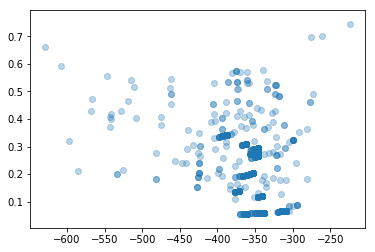

In [222]:
plt.scatter(score_list, error_rate_list, alpha=0.3)
plt.show()
#plt.hist(score_list, 50)
# the histogram of the data
#n, bins, patches = plt.hist(score_list, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

-0.3830834126407877